In [2]:
import pandas as pd
import numpy as np
from astroquery.gaia import Gaia
from typing import List
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.time import Time
from astropy.timeseries import BoxLeastSquares, TimeSeries, aggregate_downsample
from astropy.stats import sigma_clipped_stats

In [3]:
def download_lightcurves(source_ids: np.ndarray) -> List[pd.DataFrame]:
    retrieval_type = 'ALL'          # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS', 'ALL'
    data_structure = 'INDIVIDUAL'   # Options are: 'INDIVIDUAL', 'COMBINED', 'RAW'
    data_release   = 'Gaia DR3'     # Options are: 'Gaia DR3' (default), 'Gaia DR2'

    
    lightcurves: List[pd.DataFrame] = []

    datalink = Gaia.load_data(ids=source_ids,
                              data_release = data_release,
                              retrieval_type= 'EPOCH_PHOTOMETRY',
                              data_structure = data_structure,
                              verbose = False, output_file = None)
    dl_keys  = [inp for inp in datalink.keys()]
    dl_keys.sort()

    print(f'{len(dl_keys)} lightcurves found.')
    for dl_key in dl_keys:
        print(f'\tDownloading {dl_key}')
        lightcurves.append(datalink[dl_key][0].to_table().to_pandas())
        
    return lightcurves

In [4]:
def vari_short_timescale(source_ids: np.ndarray) -> pd.DataFrame:
    query = f'''
        SELECT * 
        FROM gaiadr3.vari_short_timescale 
        WHERE vari_short_timescale.source_id IN ({', '.join([str(si) for si in source_ids])})
    '''
    
    job = Gaia.launch_job_async(query, output_format='csv')
    
    return job.get_results().to_pandas()

In [5]:
bss_candidates = pd.read_csv('bss_candidates.csv')

In [6]:
yss_candidates = pd.read_csv('yss_candidates.csv')

# BSS candidates

In [7]:
bss_phot = bss_candidates[bss_candidates.phot_variable_flag=='VARIABLE']
bss_lightcurves = download_lightcurves(bss_phot.source_id.values)

2 lightcurves found.


In [8]:
short_timescale_info = vari_short_timescale(bss_phot.source_id.values)

INFO: Query finished. [astroquery.utils.tap.core]


In [9]:
short_timescale_info

,solution_id,source_id,amplitude_estimate,number_of_fov_transits,mean_of_fov_abbe_values,variogram_num_points,variogram_char_timescales,variogram_values,frequency
0,375316653866487564,573944283722429952,0.070808,45,1.00579,1,(0.176),(0.0023709204660254096),32.39746


In [10]:
bss1_lc = bss_lightcurves[0]

In [11]:
bss2_lc = bss_lightcurves[1]

In [12]:
bss2_lc.head()

,source_id,transit_id,band,time,mag,flux,flux_error,flux_over_error,rejected_by_photometry,rejected_by_variability,other_flags,solution_id
0,573968576057423360,16794185389056965,G,1700.557482,13.258732,93638.382788,97.088994,964.459290,False,False,1,375316653866487564
1,573968576057423360,16798277678981731,G,1700.631492,13.248248,94546.930254,87.650003,1078.687134,False,False,1,375316653866487564
2,573968576057423360,18920283006998245,G,1739.008450,13.239307,95328.747046,80.869795,1178.792969,False,False,1,375316653866487564
3,573968576057423360,18930023819277864,G,1739.184614,13.238245,95422.013248,70.423744,1354.969360,False,False,1,375316653866487564
4,573968576057423360,21028967752677174,G,1777.144090,13.242362,95060.910439,180.323169,527.169678,False,False,4097,375316653866487564


In [114]:
def get_dr3_band_lightcurve(lc: pd.DataFrame, band: str = 'G') -> pd.DataFrame:
    df = lc[lc.band==band][['time', 'flux', 'mag', 'flux_error']]
    df['time'] += 2455197.5
    return df

In [115]:
bss1_lc[bss1_lc.band=='G'].mag.describe()

count    45.000000
mean     14.986270
std       0.020655
min      14.939318
25%      14.973172
50%      14.983846
75%      14.998294
max      15.041255
Name: mag, dtype: float64

In [14]:
def plot_dr3_lc(lc: pd.DataFrame):
    plt.figure()
    plt.errorbar(x=lc.time, y=lc.flux, yerr=lc.flux_error, color='black', fmt='o')
    plt.gca().set_ylabel('Flux', fontsize=16);
    plt.gca().set_xlabel('Time [JD]', fontsize=16);

<IPython.core.display.Javascript object>


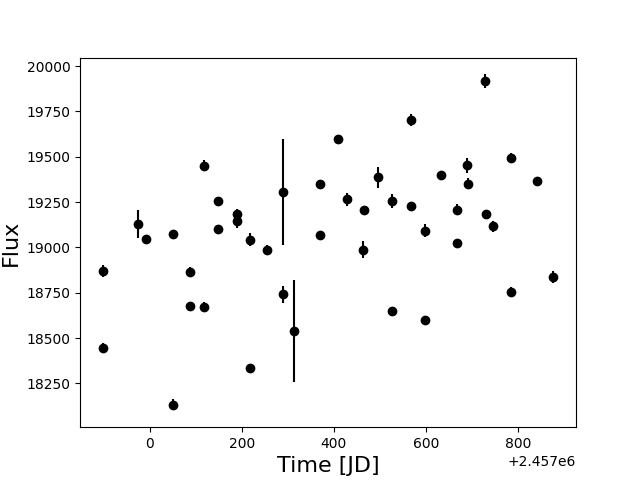

In [136]:
g_lc1 = get_dr3_band_lightcurve(bss1_lc, 'G')
plot_dr3_lc(g_lc1)

In [195]:
g_lc1.time.diff()

0           NaN
1      0.074010
2     76.586243
3     17.926968
4     58.769873
5      0.176152
6     35.714642
7      0.074018
8     29.736505
9      0.176151
10    30.491162
11     0.074006
12    40.983649
13     0.176158
14    28.749733
15     0.074008
16    36.662350
17    34.230690
18     0.074010
19    24.421255
20    55.956249
21     0.074007
22    38.699287
23    21.422164
24    34.719984
25     0.074032
26    32.410891
27    29.495098
28     0.074005
29    41.910318
30     0.074036
31    29.673806
32     0.074023
33    33.987354
34    35.401309
35     0.074038
36    22.247157
37     0.176163
38    38.951474
39     0.074035
40    17.176957
41    38.201817
42     0.074033
43    56.952797
44    34.983618
Name: time, dtype: float64

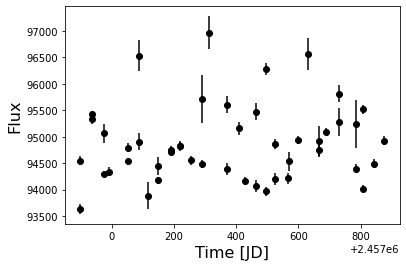

In [16]:
g_lc2 = get_dr3_band_lightcurve(bss2_lc, 'G')
plot_dr3_lc(g_lc2)

In [181]:
def create_timeseries(lc: pd.DataFrame) -> TimeSeries:
    return TimeSeries(data={'flux': lc.flux.values},
                      time=Time(lc.time.values*u.day,
                                format='jd'))

def periodogram(lc: pd.DataFrame): 
    model = BoxLeastSquares(lc.time.values*u.day, lc.flux.values)
    periods = np.linspace(10., 50., 1000)*u.day
    periodogram = model.power(periods, 0.1)
    return periodogram

def plot_periodogram(periodogram):
    plt.figure();
    plt.plot(periodogram.period, periodogram.power, color='royalblue');
    plt.gca().set_xlabel('Frequency [1/d]')
    plt.gca().set_ylabel('Power');
    
def max_period(periodogram) -> float:
    return pg.period[np.argmax(pg.power)]

In [160]:
from astropy.timeseries import LombScargle

In [192]:
frequency, power = LombScargle(g_lc1.time*u.day,
                               g_lc1.flux.values,
                               dy=g_lc1.flux_error.values).autopower(
    minimum_frequency=0.1, maximum_frequency=50)

<IPython.core.display.Javascript object>


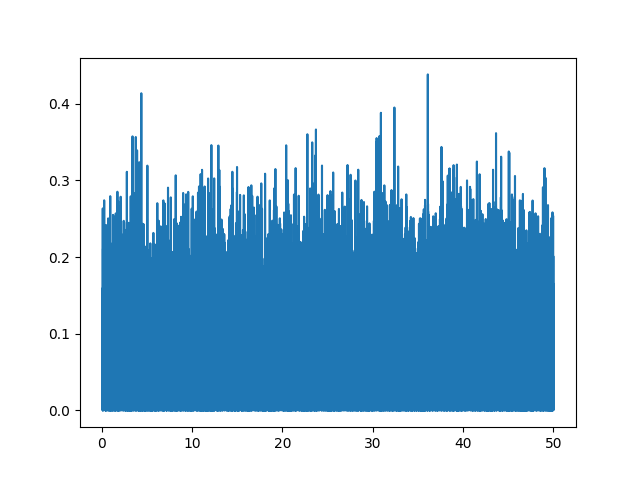

In [190]:
plt.figure();
plt.plot(frequency, power)

In [191]:
frequency[np.argmax(power)]

36.09561561505593

In [183]:
pg = periodogram(g_lc1)

In [158]:
1/32.39746

0.03086661732123444

In [125]:
ts = create_timeseries(get_dr3_band_lightcurve(bss1_lc))

In [74]:
pg.period

<Quantity [0.01      , 0.01049049, 0.01098098, 0.01147147, 0.01196196,
           0.01245245, 0.01294294, 0.01343343, 0.01392392, 0.01441441,
           0.0149049 , 0.0153954 , 0.01588589, 0.01637638, 0.01686687,
           0.01735736, 0.01784785, 0.01833834, 0.01882883, 0.01931932,
           0.01980981, 0.0203003 , 0.02079079, 0.02128128, 0.02177177,
           0.02226226, 0.02275275, 0.02324324, 0.02373373, 0.02422422,
           0.02471471, 0.02520521, 0.0256957 , 0.02618619, 0.02667668,
           0.02716717, 0.02765766, 0.02814815, 0.02863864, 0.02912913,
           0.02961962, 0.03011011, 0.0306006 , 0.03109109, 0.03158158,
           0.03207207, 0.03256256, 0.03305305, 0.03354354, 0.03403403,
           0.03452452, 0.03501502, 0.03550551, 0.035996  , 0.03648649,
           0.03697698, 0.03746747, 0.03795796, 0.03844845, 0.03893894,
           0.03942943, 0.03991992, 0.04041041, 0.0409009 , 0.04139139,
           0.04188188, 0.04237237, 0.04286286, 0.04335335, 0.04384384,
      

In [126]:
def fold(timeseries: TimeSeries, period: float):
    return timeseries.fold(period=period,
                           normalize_phase=True, wrap_phase=True)

In [129]:
folded = fold(ts, 2*0.018*u.day)

<IPython.core.display.Javascript object>


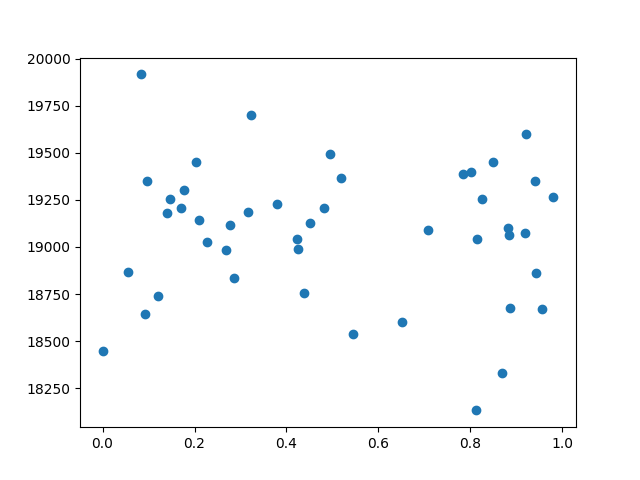

In [130]:
plt.figure()
plt.scatter(folded.time.value, folded['flux'].value)

In [21]:
mean, median, stddev = sigma_clipped_stats(folded['flux'])
folded['flux_norm'] = folded['flux'] / median

<IPython.core.display.Javascript object>


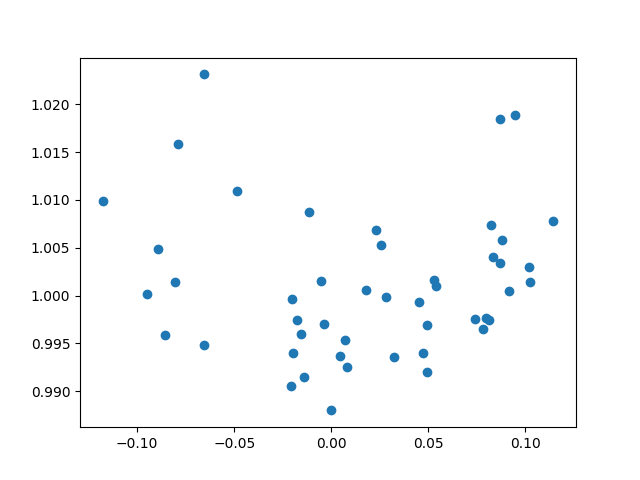

In [22]:
plt.figure()
plt.scatter(folded.time.value, folded['flux_norm'].value)

In [23]:
bss_phot[['source_id', 'TIC']]

,source_id,TIC
22,573944283722429952,461599358.0
24,573968576057423360,461601525.0


In [197]:
tic = 461601525

In [196]:
import lightkurve as lk

In [35]:
ts = lk.search_tesscut(f'TIC {int(tic)}')
print(f'Downloaded {len(ts)} tesscuts.')

Downloaded 8 tesscuts.


In [ ]:
len(yss_candidates)

In [ ]:
bss_candidates[bss_candidates.phot_variable_flag=='VARIABLE']

In [ ]:
rv = yss_candidates.dropna(subset=['rv_amplitude_robust'])

In [ ]:
rv.rv_

In [ ]:
list(yss_candidates.columns)

In [ ]:
rv_yss = yss_candidates[yss_candidates.rv_amplitude_robust>=6*yss_candidates.radial_velocity_error]

In [ ]:
rv.rv_amplitude_robust

In [ ]:
rv.radial_velocity_error

In [ ]:
rv.rv_renormalised_gof